# Enhancement

In [213]:
import requests
import json
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from matplotlib import pylab as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pymongo
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import pickle
pio.templates.default = "plotly_dark"

## 1. Retrieve Data from MongoDB
Retreive all documents from MongoDB and convrt it to a `pandas.DataFrame`

In [214]:
# Read data from MongoDB
client = pymongo.MongoClient()
db = client.get_database("MarsWeather")
collection = db.get_collection("DailyWeather")
df = pd.DataFrame(list(collection.find()))
df

,_id,date,max_temp,min_temp,pressure,sol_day,wind
0,5df3f5f44313285b4fdcc1e3,2019-12-04T04:41:02Z,-21.174,-98.548,665.169,361,"{'1': {'compass_degrees': 22.5, 'compass_point..."
1,5df3f5f44313285b4fdcc1e5,2019-12-05T05:20:37Z,-21.075,-99.804,664.490,362,"{'0': {'compass_degrees': 0.0, 'compass_point'..."
2,5df3f5f44313285b4fdcc1e7,2019-12-06T06:00:12Z,-20.347,-99.893,663.455,363,"{'0': {'compass_degrees': 0.0, 'compass_point'..."
3,5df3f5f44313285b4fdcc1e9,2019-12-06T06:00:12Z,-20.347,-99.893,663.455,364,"{'0': {'compass_degrees': 0.0, 'compass_point'..."
4,5df3f5f44313285b4fdcc1eb,2019-12-07T06:39:47Z,-21.531,-98.800,662.454,365,"{'0': {'compass_degrees': 0.0, 'compass_point'..."
5,5df3f5f44313285b4fdcc1ed,2019-12-08T00:34:43Z,-20.442,-98.941,660.866,366,"{'10': {'compass_degrees': 225.0, 'compass_poi..."
6,5df3f5f44313285b4fdcc1ef,2019-12-09T07:58:59Z,-20.914,-139.936,661.043,367,"{'1': {'compass_degrees': 22.5, 'compass_point..."
7,5df3f5f44313285b4fdcc1f1,2019-12-10T08:38:35Z,-20.919,-100.049,660.436,368,"{'1': {'compass_degrees': 22.5, 'compass_point..."
8,5df3f5f44313285b4fdcc1f3,2019-12-11T09:18:10Z,-21.164,-98.234,659.424,369,"{'1': {'compass_degrees': 22.5, 'compass_point..."
9,5df3f5f44313285b4fdcc1f5,2019-12-12T09:57:46Z,-19.470,-98.970,658.193,370,"{'0': {'compass_degrees': 0.0, 'compass_point'..."


## 2 Temperature and weather predition
We use vector autoregression to make the predictions. Each of the graph includes the historical weather of the past 7 days 
        and the prediction of the max, min temperature, and the average atmospheric pressure respectively. 
        The solid line records the historical data, while the dashed line shows the predictions. 
        The band around the dashed line presents the 95% confidence interval of the predictions. 
        It gets wider as there exists more uncertainty into the farther future.  
        User adjust the predicted days ahead by moving the slider horizontally. 


### 2.1 Train model

In [215]:
# Clean data
df_train = pd.read_csv("mars_weather.csv")
# Take the time needed to train
df_train = df_train[(df_train['sol'] >= 1815) & (df_train['sol'] <= 1945)]
df_test = pd.read_csv("mars_weather.csv")
# Split test
df_test = df_test[(df_test['sol'] >= 1946) & (df_test['sol'] <= 1976)]
df_train.drop(["id", "terrestrial_date", "sol", "ls", "month", "wind_speed", "atmo_opacity"], 
        axis=1, inplace=True)
df_test.drop(["id", "terrestrial_date", "sol", "ls", "month", "wind_speed", "atmo_opacity"], 
        axis=1, inplace=True)
df_train.head()

,min_temp,max_temp,pressure
32,-78.0,-22.0,754.0
33,-80.0,-21.0,755.0
34,-78.0,-28.0,756.0
35,-78.0,-27.0,757.0
36,-77.0,-20.0,758.0


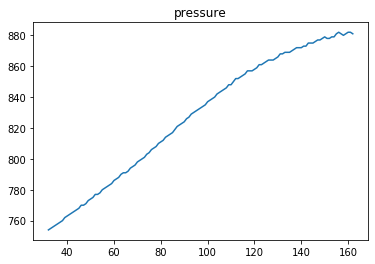

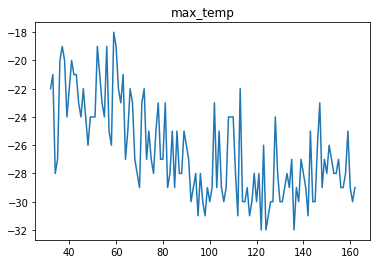

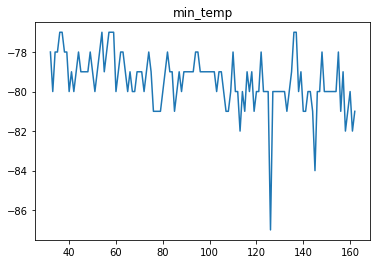

In [216]:
# Plot for three subjects
subjects = ["pressure", "max_temp", "min_temp"]
for subject in subjects:
    plt.plot(df_train[subject])
    plt.title(subject)
    plt.show()

Not stable, need to take order 1 differnce. From the figures below, we can see the subjects are stable. 

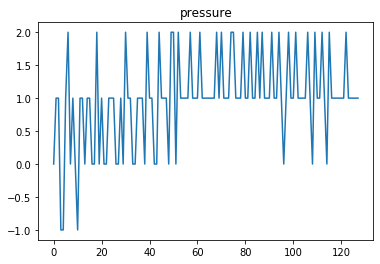

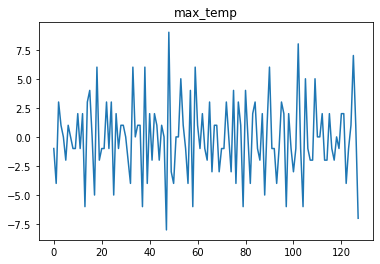

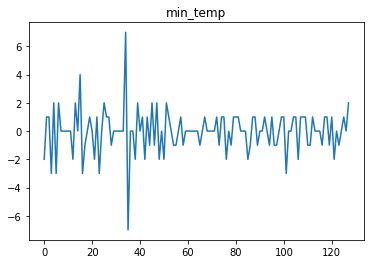

In [217]:
def diff_data(df):
    """Take a dataframe, return differenced dataframe"""
    df_diff = {}
    for subject in subjects:
        temp = []
        index = df.index
        end, start = index[-1], index[1]
        for i in range(end - 1, start, -1):
            temp.append(df[subject][i] - df[subject][i - 1])
        df_diff[subject] = temp
    df_diff = pd.DataFrame(df_diff)
    return df_diff

# Take order 1 diff on all subjects
df_diff = diff_data(df_train)

# Plot for three subjects after diff
subjects = ["pressure", "max_temp", "min_temp"]
for subject in subjects:
    plt.plot(df_diff[subject])
    plt.title(subject)
    plt.show()

In [218]:
# Impute with random forest
rf_imputer = IterativeImputer(estimator = 
               RandomForestRegressor(max_depth=2, n_estimators=30, n_jobs=-1), 
                               random_state=42)
x_impute = rf_imputer.fit_transform(df_train)
x_impute = pd.DataFrame(x_impute, columns = df_train.columns)
x_impute_origin = x_impute
model_origin = VAR(x_impute_origin)

In [219]:
# Baseline model, VAR(0)
lag = 0
base = model_origin.fit(lag)
base.bic

9.751590869989874

In [220]:
# Best model, VAR(3)
lag = 3
results_origin = model_origin.fit(lag)
results_origin.bic

2.190161786329473

## 3 MSE on Test set
Use next month to test, we can see that MSE on test is lower for our model than the baseline

In [221]:
base_mse = 0
for subject in subjects:
    base_mse += np.square(np.subtract(df_test[subject][3:30], df_test[subject][4:31])).mean()
base_mse

21.62962962962963

In [222]:
res_pred, result_mse = [], 0
for i in range(3, 30):
    res_pred.append(results_origin.forecast(df_test[['min_temp', 'max_temp', 'pressure']].iloc[i-3:i].values, 1)[0])
res_pred = pd.DataFrame(res_pred, columns=["min_temp", "max_temp", "pressure"])
for subject in subjects:
    result_mse += np.square(np.subtract(res_pred[subject], df_test[subject][4:31])).mean()
result_mse

16.546305229973967

In [223]:
pd.DataFrame([base_mse, result_mse], columns=["MSE"], index=["baseline mode", "bset mode"])

,MSE
baseline mode,21.629630
bset mode,16.546305


## 4 Plot Results of Prediction

In [224]:
def predict_plots(step, df):
    """Take steps to predict and dataframe used for prediction, returns plot of prediction"""
    main_keys = df['sol_day'].values
    model = results_origin
    sol_days_pred = [int(main_keys[-1]) + i for i in range(0, step + 1)]    # Sol days to predict
    pred = model.forecast_interval(df[['min_temp', 'max_temp', 'pressure']].iloc[-3:].values, step)    # Predictions needed
    prev_max_temp = list(df["max_temp"])    # Previous max temperatures

    # set up 
    fig = make_subplots(rows=3, cols=1, subplot_titles=("Max Temperature", "Min Temperature", "Average Pressure",))
    
    # plot max temperature
    prev_max_temp = list(df["max_temp"])    # Previous max temperatures
    max_temp_dic = {}    # Record predicted max temperature and confidence intervals
    for i in range(0, 3):
        max_temp_dic['temp_exp'] = [prev_max_temp[-1]] + [i[1] for i in pred[0]]
        max_temp_dic['temp_lower'] = [prev_max_temp[-1]] +  [i[1] for i in pred[1]]
        max_temp_dic['temp_upper'] = [prev_max_temp[-1]] +  [i[1] for i in pred[2]]
    fig.add_trace(go.Scatter(x=df['sol_day'], y=prev_max_temp,
                         mode='lines', 
                         name='Known Max Temperature', 
                         line_color='rgb(255, 102, 163)',
                         showlegend=False, 
                         ), row=1, col=1)
    fig.add_trace(go.Scatter(x=sol_days_pred, y=max_temp_dic['temp_exp'],
                         mode='lines', 
                         line=dict(dash='dash'), 
                         line_color='rgb(255, 102, 163)', 
                         name='Expected Max Temperature'), row=1, col=1)
    fig.add_trace(go.Scatter(x=sol_days_pred, y=max_temp_dic['temp_upper'],
                         mode='lines',
                         name='Interval of Max Temperature', 
                         line_color='rgba(255, 102, 163, 0.2)', 
                         showlegend=False), row=1, col=1)
    fig.add_trace(go.Scatter(x=sol_days_pred, y=max_temp_dic['temp_lower'],
                         mode='lines',
                         name='Interval of Max Temperature', 
                         fill='tonexty', 
                         line_color='rgba(255, 102, 163, 0.2)', 
                         fillcolor='rgba(255, 102, 163, 0.2)'), row=1, col=1)
    fig.update_xaxes(title_text="Sol Day", row=1, col=1)
    fig.update_yaxes(title_text="Degrees of Celcius", row=1, col=1)
    
    # plot min temperature
    prev_min_temp = list(df["min_temp"])    # Previous min temperatures
    min_temp_dic = {}    # Record predicted min temperature and confidence intervals
    for i in range(0, 3):
        min_temp_dic['temp_exp'] = [prev_min_temp[-1]] + [i[0] for i in pred[0]]
        min_temp_dic['temp_lower'] = [prev_min_temp[-1]] +  [i[0] for i in pred[1]]
        min_temp_dic['temp_upper'] = [prev_min_temp[-1]] +  [i[0] for i in pred[2]]
    fig.add_trace(go.Scatter(x=df['sol_day'], y=prev_min_temp,
                         mode='lines', 
                         name='Known Max Temperature', 
                         line_color='rgb(102, 181, 255)',
                         showlegend=False), row=2, col=1)
    fig.add_trace(go.Scatter(x=sol_days_pred, y=min_temp_dic['temp_exp'],
                         mode='lines', 
                         line=dict(dash='dash'), 
                         line_color='rgb(102, 181, 255)', 
                         name='Expected Min Temperature'), row=2, col=1)
    fig.add_trace(go.Scatter(x=sol_days_pred, y=min_temp_dic['temp_upper'],
                         mode='lines',
                         name='Interval of Min Temperature', 
                         line_color='rgba(102, 181, 255, 0.2)', 
                         showlegend=False), row=2, col=1)
    fig.add_trace(go.Scatter(x=sol_days_pred, y=min_temp_dic['temp_lower'],
                         mode='lines',
                         name='Interval of Min Temperature', 
                         fill='tonexty', 
                         line_color='rgba(102, 181, 255, 0.2)', 
                         fillcolor='rgba(102, 181, 255, 0.2)'), row=2, col=1)
    fig.update_xaxes(title_text="Sol Day", row=2, col=1)
    fig.update_yaxes(title_text="Degrees of Celcius", row=2, col=1)
    
    # plot avg temperature
    prev_ps = list(df['pressure'])    # Previous max temperatures
    ps_dic = {}    # Record predicted max temperature and confidence intervals
    for i in range(0, 3):
        ps_dic['ps_exp'] = [prev_ps[-1]] + [i[2] for i in pred[0]]
        ps_dic['ps_lower'] = [prev_ps[-1]] +  [i[2] for i in pred[1]]
        ps_dic['ps_upper'] = [prev_ps[-1]] +  [i[2] for i in pred[2]]
    fig.add_trace(go.Scatter(x=df['sol_day'], y=prev_ps,
                         mode='lines', 
                         name='Known Avg Pressure', 
                         line_color='rgb(102, 255, 179)',
                         showlegend=False), row=3, col=1)
    fig.add_trace(go.Scatter(x=sol_days_pred, y=ps_dic['ps_exp'],
                         mode='lines', 
                         line=dict(dash='dash'), 
                         line_color='rgb(102, 255, 179)', 
                         name='Expected Avg Pressure'), row=3, col=1)
    fig.add_trace(go.Scatter(x=sol_days_pred, y=ps_dic['ps_upper'],
                         mode='lines',
                         name='Interval of Avg Pressure', 
                         line_color='rgba(102, 255, 179, 0.2)', 
                         showlegend=False), row=3, col=1)
    fig.add_trace(go.Scatter(x=sol_days_pred, y=ps_dic['ps_lower'],
                         mode='lines',
                         name='Interval of Avg Pressure', 
                         fill='tonexty', 
                         line_color='rgba(102, 255, 179, 0.2)', 
                         fillcolor='rgba(102, 255, 179, 0.2)'), row=3, col=1)
    fig.update_xaxes(title_text="Sol Day", row=3, col=1)
    fig.update_yaxes(title_text="Pascal", row=3, col=1)
    
    fig.update_layout(width=1200, height=700)
    
    return fig


fig = predict_plots(5, df)
fig.show()